# Beamforming with a `Wavefront` that returns multiple distance samples
This notebook showcases an "advanced" implementation of a `Wavefront` model that returns multiple transmit distance samples.

The wavefront model that we will implement in this notebook is called `SmoothedWavefront`. It takes another wavefront model and an array of distance offsets as arguments, and when we calculate the `transmit_distance` the offsets are added to the result. If the offsets are small enough then this is the same as smoothing in the time-axis.

This is only to showcase `vbeam`'s flexibility and support for different types of wavefront models. There are better ways to smooth along the time-axis than using a custom `Wavefront` class.

## Loading example data
Let's start by loading a dataset. We use the `PICMUS_carotid_cross.uff`, downloaded from www.ustb.no, which is a plane wave imaging setup. We rescale the scan grid to `(100, 100)` in order to speed up the beamforming. We use the "default" beamformer created by `vbeam` by calling `get_beamformer(setup)`.

In this notebook we use JAX as the computation backend.

/home/magnusk/miniconda3/envs/vbeam/lib/python3.9/site-packages/pyuff_ustb/readers/lazy_arrays/base.py:103: RuntimeWarning: invalid value encountered in multiply
  return self[...] * other
/home/magnusk/vbeam/vbeam/data_importers/setup.py:45: UserWarning: point_position will be overwritten by the scan.
  warnings.warn("point_position will be overwritten by the scan.")


(-0.5, 99.5, 99.5, -0.5)

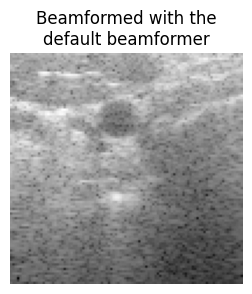

In [1]:
import jax
import matplotlib.pyplot as plt
import pyuff_ustb as pyuff

from vbeam.beamformers import get_das_beamformer
from vbeam.data_importers import import_pyuff
from vbeam.fastmath import backend_manager
from vbeam.util.download import cached_download

# Tell vbeam that we are using JAX
backend_manager.active_backend = "jax"
# Download (or read from cache) and load the UFF file
data_url = "http://www.ustb.no/datasets/PICMUS_carotid_cross.uff"
uff = pyuff.Uff(cached_download(data_url))
# Import the channel data and scan configuration from the UFF file
setup = import_pyuff(uff.read("/channel_data"), uff.read("/scan"), frames=0)
# Resize the grid to make the beamforming faster (though the image will be undersampled)
setup.scan = setup.scan.resize(x=100, z=100)

# Create a "default" beamformer. Wrap it in jax.jit to make it run fast with JAX :)
beamformer = jax.jit(get_das_beamformer(setup))
# Beamform the imported data
result = beamformer(**setup.data)

# Plot the result
plt.figure(figsize=(3, 3))
plt.title("Beamformed with the\ndefault beamformer")
plt.imshow(result.T, aspect="auto", cmap="gray"); plt.axis("off")


## Defining the `SmoothedWavefront` class
For calculating the transmit distance, the `SmoothedWavefront` will return the distance from another given wavefront model with some offsets added to it. For example, if the distance is `0.1` and the offsets are `[-1, 0, 1]`, then the returned transmit distances will be `[0.1-1, 0.1+0, 0.1+1]` = `[-0.9, 0.1, 1.1]`.

The result of using `SmoothedWavefront` is a more smooth image. This can be seen when comparing the default beamformer image with the one that uses `SmoothedWavefront`.

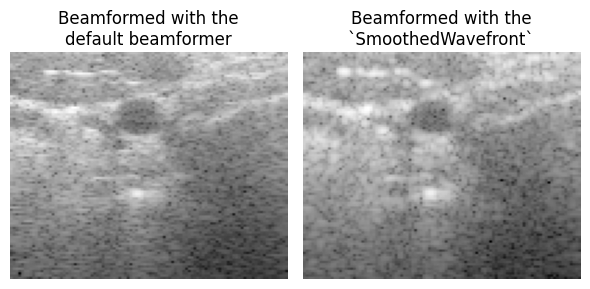

In [2]:
import jax.numpy as jnp

from vbeam.core import ElementGeometry, MultipleTransmitDistances, WaveData, Wavefront
from vbeam.fastmath.traceable import traceable_dataclass
from vbeam.apodization import Hamming


@traceable_dataclass(("base_wavefront", "offsets"))
class SmoothedWavefront(Wavefront):
    # The wavefront that we are adding the offsets to
    base_wavefront: Wavefront
    # The offsets: an array of shape (N,), where N are the number of distance offsets
    offsets: jnp.ndarray

    def transmit_distance(
        self,
        sender: ElementGeometry,
        point_position: jnp.ndarray,
        wave_data: WaveData,
    ) -> MultipleTransmitDistances:
        # Calculate the distance to the point
        distance = self.base_wavefront.transmit_distance(
            sender, point_position, wave_data
        )

        # Add the offsets to the distance
        offset_distances = self.offsets + distance

        # Let's weight the offset samples using Hamming (arbitrarily chosen)
        weights = Hamming()(jnp.linspace(-0.5, 0.5, self.offsets.shape[0]))

        # Return a weighted sum of the samples
        aggregate_samples = lambda samples: jnp.sum(samples * weights)
        return MultipleTransmitDistances(offset_distances, aggregate_samples)

    def receive_distance(
        self,
        point_position: jnp.ndarray,
        receiver: ElementGeometry,
        wave_data: WaveData,
    ) -> float:
        # The receive distance is just returned as-is.
        return self.base_wavefront.receive_distance(point_position, receiver, wave_data)


# We create a SmoothedWavefront with 5 offsets in the range [-2 mm, 2 mm]
smoothed_wavefront = SmoothedWavefront(setup.wavefront, jnp.linspace(-2e-3, 2e-3, 5))
smoothed_result = beamformer(**{**setup.data, "wavefront": smoothed_wavefront})

fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
ax[0].set_title("Beamformed with the\ndefault beamformer")
ax[0].imshow(result.T, aspect="auto", cmap="gray")
ax[0].axis("off")
ax[1].set_title("Beamformed with the\n`SmoothedWavefront`")
ax[1].imshow(smoothed_result.T, aspect="auto", cmap="gray")
ax[1].axis("off")
fig.tight_layout()